In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tusud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [20]:
# load the data

data = pd.read_csv("amazon_alexa.tsv", delimiter='\t', quoting=3)
print(data.shape)

(3150, 5)


In [21]:
data.head(3)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1


In [22]:
print(f'Feature names:{data.columns.values}')

Feature names:['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [23]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [24]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [25]:
data.dropna(inplace = True)

In [26]:
print(f'Dataset shape after dropping null values :{data.shape}')

Dataset shape after dropping null values :(3149, 5)


In [27]:
# creating the new column 'length' that will contain the length of the string in 'verified_reviews'

data['length'] = data['verified_reviews'].apply(len)
data.head(3)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197


In [28]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

##### Analyzing rating column

In [29]:
# Distint values of 'rating' and its count

print(f'Rating value count: \n{data["rating"].value_counts()}')

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


lets plot the above values in a bar graph

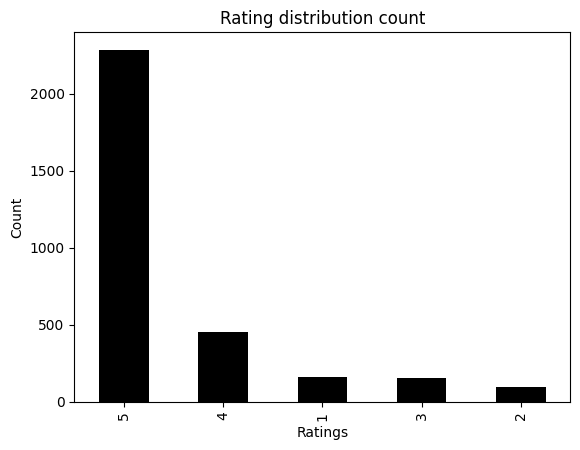

In [30]:
# Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'bLACK')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [31]:
print(f'Rating value count - percentage distribution: \n{round(data["rating"].value_counts()/data.shape[0]*100)}')

Rating value count - percentage distribution: 
rating
5    73.0
4    14.0
1     5.0
3     5.0
2     3.0
Name: count, dtype: float64


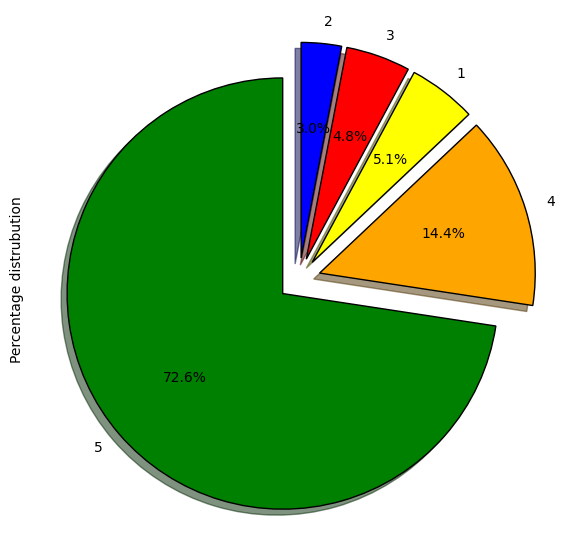

In [50]:
fig = plt.figure(figsize=(7,7))

colors = {'red', 'green', 'blue', 'orange', 'yellow'}
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,)*len(tags)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage distrubution')
# Save the figure
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format='png')
graph.seek(0)  # Move to the beginning of the BytesIO buffer
plt.show()

##### Analyzing 'feedback' column

In [51]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [52]:
# Extracting the 'verified reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [53]:
# Extracting the 'verified_revies' value for one rcord with feedback = 1
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


In [54]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.verified_reviews)

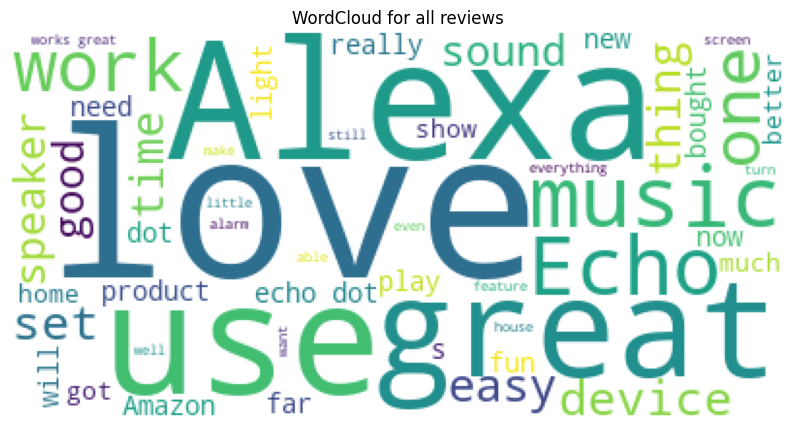

In [55]:
# combine all the reviews
reviews = ''.join([review for review in data['verified_reviews']])

# Inital wordcloud object 
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews')
plt.axis('off')
plt.show()

In [56]:
# combine all reviews for each following category ans splitting them into idividual words

neg_reviews = ' '.join([review for review in data[data['feedback'] == 0]["verified_reviews"]])
neg_reviews = neg_reviews.lower().split()

pos_reviews = ' '.join([review for review in data[data['feedback'] == 1]["verified_reviews"]])
pos_reviews = pos_reviews.lower().split()

# finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

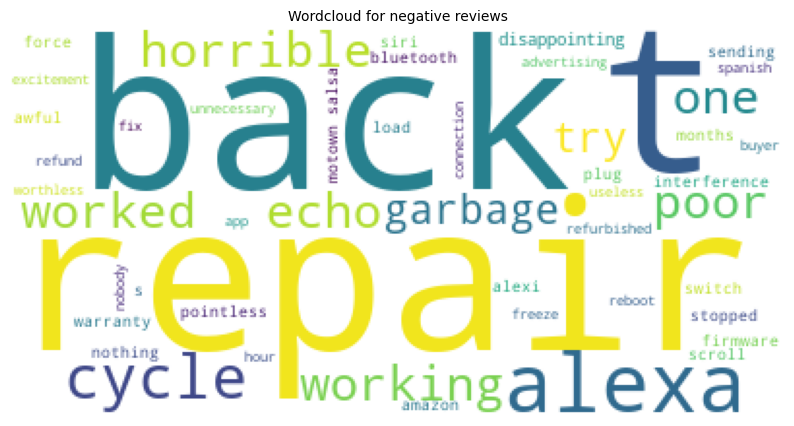

In [57]:
wc = WordCloud(background_color='white', max_words=50)

#Generate and plot wordcloud
plt.figure(figsize= (10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize = 10)
plt.axis('off')
plt.show()

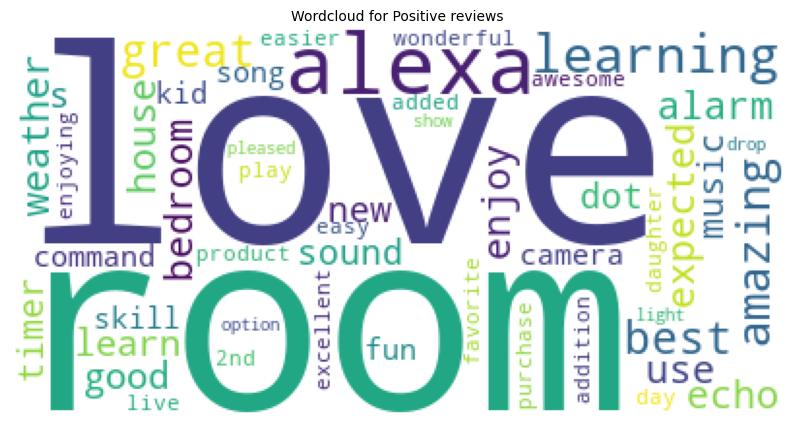

In [58]:
wc = WordCloud(background_color='white', max_words=50)

#Generate and plot wordcloud
plt.figure(figsize= (10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for Positive reviews', fontsize = 10)
plt.axis('off')
plt.show()

### Preprocessing and Modeling
To build the corpus from the 'verified_reviews' we perform the following-
 1. Replace any non alphabet charaters with a space
 2. Convert to lower case and split into words
 3. Iterate over the Individial words and if it is not a stopwords then add the stemmed form of the word to the corpus

In [59]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('^[a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [60]:
cv = CountVectorizer(max_features=2500)

X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [61]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [62]:
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

X Shape: (3149, 2500)
y Shape: (3149,)


In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=15)

In [64]:
print(f'X train Shape: {X_train.shape}')
print(f'y train Shape: {y_train.shape}')
print(f'X test Shape: {X_test.shape}')
print(f'y test Shape: {y_test.shape}')

X train Shape: (2204, 2500)
y train Shape: (2204,)
X test Shape: (945, 2500)
y test Shape: (945,)


In [74]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [75]:
# saving the scaler model
pickle.dump(scaler, open("scaler.pkl", 'wb'))

### Random Forest

In [67]:
# fitting scaled X_train and y_train on Random Forest Classifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [77]:
# Accuracy of the model on training and testing data


print('Training Accuracy :', model_rf.score(X_train_scl, y_train))
print('Testing Accuracy :', model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9950090744101633
Testing Accuracy : 0.9386243386243386


In [79]:
# Prediction on the test set
y_preds = model_rf.predict(X_test_scl)

In [81]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds) 

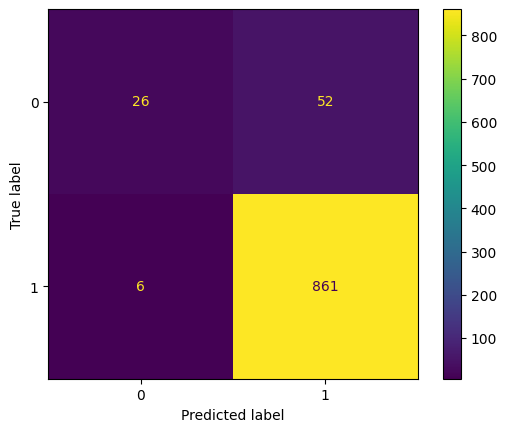

In [82]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K Fold cross-validation

In [83]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print('Accuracy:', accuracies.mean())
print('Standard Variances:', accuracies.std())

Accuracy: 0.9333011106540517
Standard Variances: 0.010575783694752972


In [84]:
params = {
    'bootstrap':[True],
    'max_depth': [80, 100],
    'min_sample_split': [8,12],
    'n_estimators':[100,300]
}

In [89]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator= model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train.ravel())

ValueError: Invalid parameter 'min_sample_split' for estimator RandomForestClassifier(max_depth=80). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

### XgBoost 

In [90]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
model_xgb.score(X_train_scl, y_train)

0.9732304900181489

In [93]:
model_xgb.score(X_test_scl, y_test)

0.9333333333333333

In [96]:
y_preds  = model_xgb.predict(X_test)

In [98]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[ 29,  49],
       [ 17, 850]], dtype=int64)